In [23]:
import os
import json
import pandas as pd

In [24]:
osg_hosts = [x for x in os.listdir('./') if 'osg' in x]

In [25]:
selected_keys = ["GlobalJobId", "JOBGLIDEIN_ResourceName", "JobDuration", "JobPrio", "JobStartDate", "CompletionDate", "JobState", "DiskProvisioned", "DiskUsage", "DiskUsage_RAW", "BlockReadKbytes", "BlockWriteKbytes", "CpusProvisioned", "CPUsUsage", "MemoryProvisioned", "ResidentSetSize", "GpusProvisioned"]

In [26]:
def step1(file):
    data = []
    temp = {}
    with open(file) as f:
        while True:
            line = f.readline()
            if not line:
                break
            line = line.split('=')
            for i in range(len(line)-1):
                key = line[i].strip('\n "')
                if key not in selected_keys:
                    continue
                try:
                    value = line[i+1].strip('\n "')
                except Exception as ex:
                    print(line, ex)
                if key not in temp:
                    temp.update({key: value})
                else:
                    data.append(temp)
                    temp = {key: value}
    data = pd.DataFrame(data)
    data = data.dropna(axis=0)
    data['MemoryUsage'] = (data['ResidentSetSize'].astype(int) + 1023)/1024
    return data

In [27]:
df1 = step1(osg_hosts[0])
df2 = step1(osg_hosts[1])
df3 = step1(osg_hosts[2])
df = pd.concat([df1, df2, df3], axis=0)
df.sort_values(by=['JobStartDate'], inplace=True)
df.set_index(['GlobalJobId'], inplace=True)
df.to_csv('osg_jobs.csv')

In [28]:
df.shape

(10317, 17)

In [29]:
df.head(3)

,BlockReadKbytes,BlockWriteKbytes,CPUsUsage,CompletionDate,CpusProvisioned,DiskProvisioned,DiskUsage,DiskUsage_RAW,GpusProvisioned,JOBGLIDEIN_ResourceName,JobDuration,JobPrio,JobStartDate,JobState,MemoryProvisioned,ResidentSetSize,MemoryUsage
GlobalJobId,,,,,,,,,,,,,,,,,
scott.grid.uchicago.edu#2537767.0#1624554806,0,0,0.9980153905578483,1624559416,1,8526265,257286,44,0,chameleon-uc-dev-backfill,3709.397162,0,1624555690,Exited,8192,3010868,2941.299805
scott.grid.uchicago.edu#2537774.0#1624554806,0,0,0.9973476109602976,1624559408,1,8526265,257241,44,0,chameleon-uc-dev-backfill,3708.727951,0,1624555691,Exited,8192,2983436,2914.510742
scott.grid.uchicago.edu#2537781.0#1624554807,0,0,0.997347006945318,1624559416,1,8526265,257248,44,0,chameleon-uc-dev-backfill,3708.175542,0,1624555691,Exited,8192,3008120,2938.616211


In [31]:
df_end = df.sort_values('CompletionDate')
df_end['merge_date'] = df_end['CompletionDate']
df_end['flag'] = ['end'] * df_end.shape[0]

df_start = df.sort_values('JobStartDate')
df_start['merge_date'] = df_start['JobStartDate']
df_start['flag'] = ['start'] * df_start.shape[0]

df_temp = pd.concat([df_start, df_end], axis=0)
df_temp.sort_values(by=['merge_date'], inplace=True)

<AxesSubplot:>

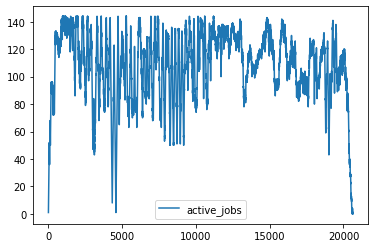

In [32]:
num_jobs = 0
data = []
for index, row in df_temp.iterrows():
    if row['flag'] == 'start':
        num_jobs += 1
    else:
        num_jobs -= 1
    data.append(num_jobs)

data = pd.DataFrame(data, columns=['active_jobs'])
data.plot()